
# Лабораторная работа №4

## Линейные модели, SVM и деревья решений

##### Выполнил: Борисочкин М. И., РТ5-61Б


### Текстовое описание набора данных

Для обучения моделей был выбран набор данных по недельным продажам в сети магазинов Walmart ([Walmart Dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset)). На основе данного датасета будем решать задачу регресии.

В данном наборе данных присутствуют следующие столбцы:
- Store — номер магазина;
- Date — дата начала недели продаж;
- Weekly_Sales — недельные продажи магазина. Является целевым признаком;
- Holiday_Flag — бинарный признак отсутствия/наличния (0/1) праздника;
- Temperature — температура в день продаж;
- Fuel_Price — цена топлива в регионе;
- CPI — [индекс потребительских цен](https://ru.wikipedia.org/wiki/Индекс_потребительских_цен);
- Unemployment — показатель безработицы.


### Импорт библиотек


In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

%matplotlib inline
sns.set(style='whitegrid')


### Загрузка данных

In [2]:
# Загрузка датасета
data : pd.DataFrame = pd.read_csv('data/Walmart.csv')


### Разведочный анализ данных

In [3]:
# Первые пять строк датасета
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
# Последние пять строк датасета
data.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


In [5]:
# Размер датасета
data.shape

(6435, 8)

In [6]:
# Типы столбцов
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [7]:
# Пустые значения
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [8]:
# Дублирующиеся значения
data.duplicated().sum()

0

Для дальнешего анализа данных разделим поле Date на неделю, месяц и год:

In [9]:
# Разделение поля Date
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Удаление столбца Date
data = data.drop(columns=['Date'])

# Перестановка столбцов
data = data[['Store', 'Week', 'Month', 'Year', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']]
data.head()

,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,5,2,2010,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,6,2,2010,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,7,2,2010,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,8,2,2010,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,9,3,2010,0,46.50,2.625,211.350143,8.106,1554806.68


In [10]:
# Типы новых колонок
data[['Week', 'Month', 'Year']].dtypes

Week     UInt32
Month     int64
Year      int64
dtype: object

Приведём столбец Week к правильному типу:

In [11]:
# Измение типа столбца Week
data['Week'] = data['Week'].astype('int64')
data['Week'].dtype

dtype('int64')

In [12]:
# Статистические характеристки датасета
data.describe()

,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6.435000e+03
mean,23.000000,25.818182,6.447552,2010.965035,0.069930,60.663782,3.358607,171.578394,7.999151,1.046965e+06
std,12.988182,14.129201,3.238308,0.797019,0.255049,18.444933,0.459020,39.356712,1.875885,5.643666e+05
min,1.000000,1.000000,1.000000,2010.000000,0.000000,-2.060000,2.472000,126.064000,3.879000,2.099862e+05
25%,12.000000,14.000000,4.000000,2010.000000,0.000000,47.460000,2.933000,131.735000,6.891000,5.533501e+05
50%,23.000000,26.000000,6.000000,2011.000000,0.000000,62.670000,3.445000,182.616521,7.874000,9.607460e+05
75%,34.000000,38.000000,9.000000,2012.000000,0.000000,74.940000,3.735000,212.743293,8.622000,1.420159e+06
max,45.000000,52.000000,12.000000,2012.000000,1.000000,100.140000,4.468000,227.232807,14.313000,3.818686e+06


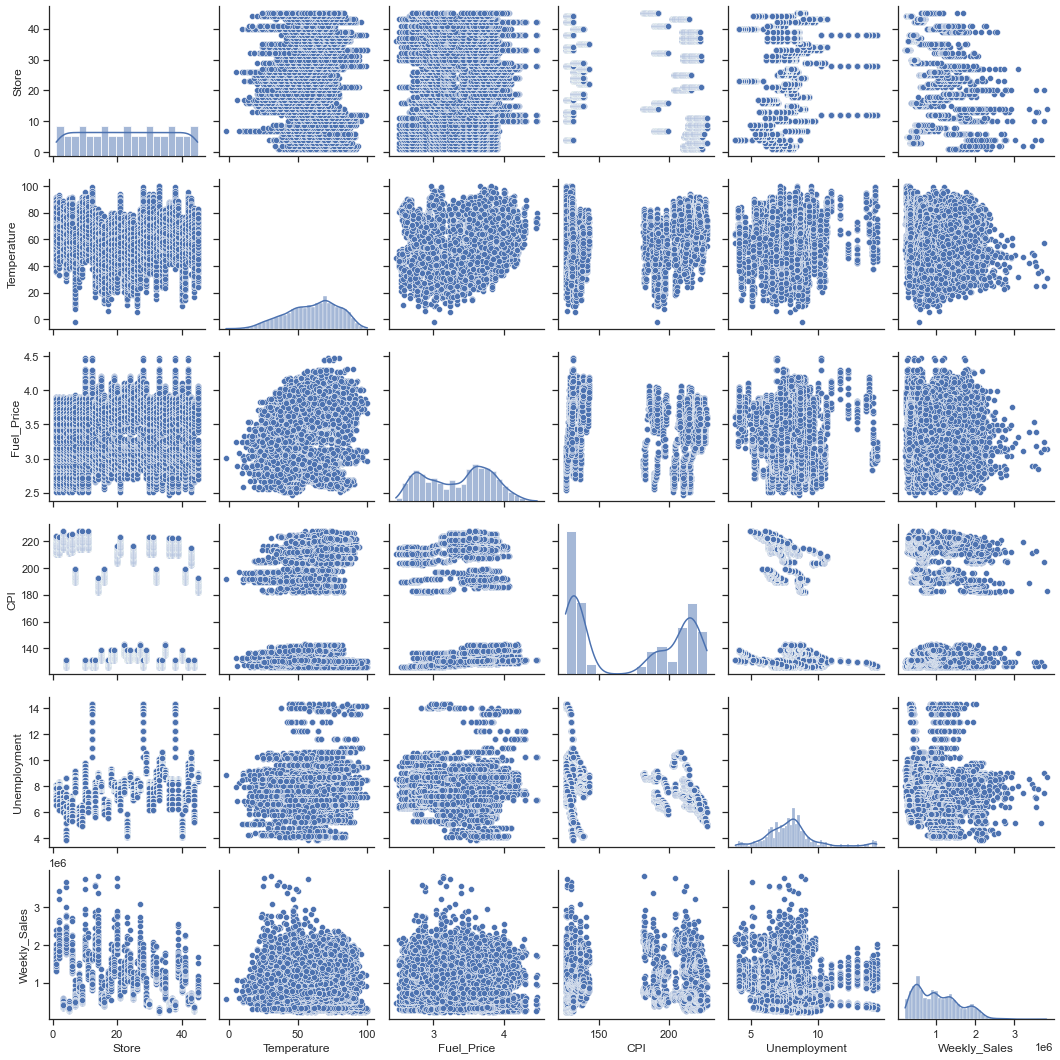

In [13]:
# Парные диаграммы
with sns.axes_style('ticks'):
    sns.pairplot(data=data[['Store','Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']],
                 diag_kws=dict(kde=True))
    plt.show()

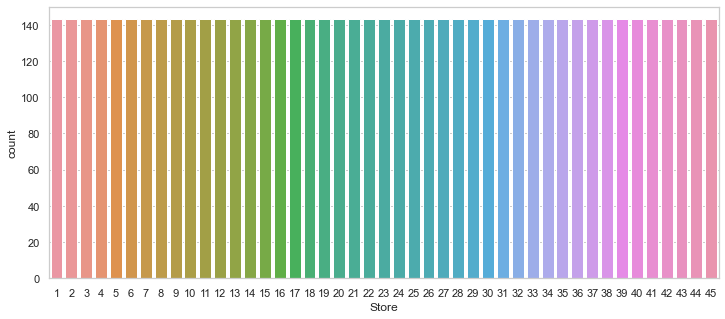

In [14]:
# Распределение по магазинам
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Store'], ax=ax)
plt.show()

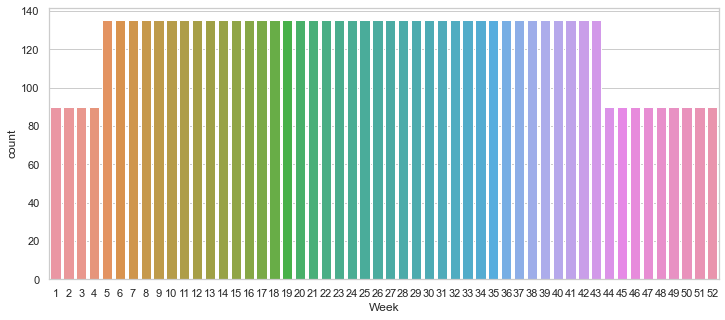

In [15]:
# Распределение по неделям
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Week'], ax=ax)
plt.show()

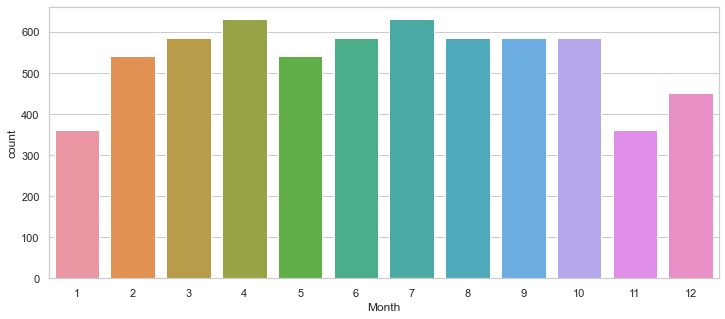

In [16]:
# Распределение по месяцам
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Month'], ax=ax)
plt.show()

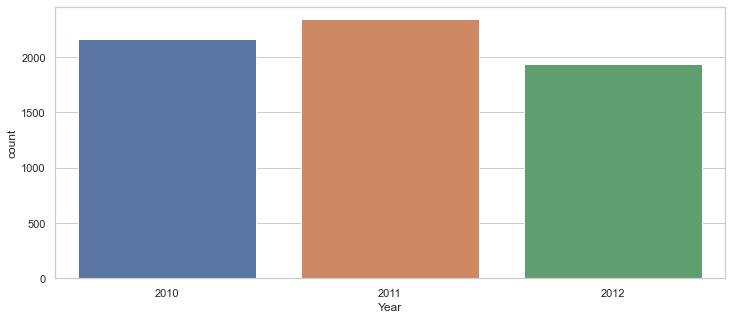

In [17]:
# Распределение по годам
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Year'], ax=ax)
plt.show()

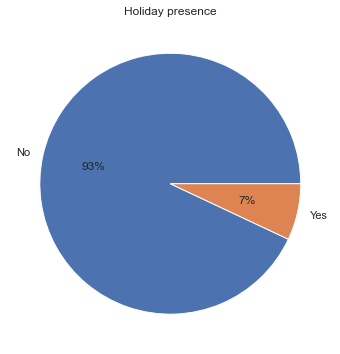

In [18]:
# Распределение праздников
_, ax = plt.subplots(figsize=(6,6))
plt.pie(data['Holiday_Flag'].value_counts(), labels=['No', 'Yes'], autopct='%.0f%%')
plt.title('Holiday presence')
plt.show()

Так как SVM модель чувствительна к выбросам построим графики ящиков с усами:

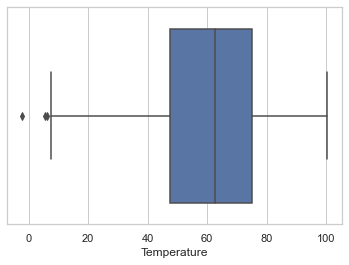

In [19]:
# Ящик с усами для столбца Temperature
sns.boxplot(x=data['Temperature'])
plt.show()

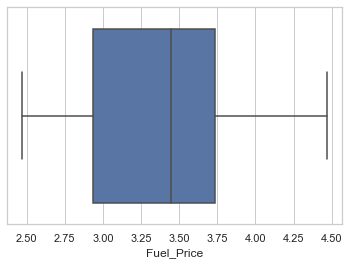

In [20]:
# Ящик с усами для столбца Fuel_Price
sns.boxplot(x=data['Fuel_Price'])
plt.show()

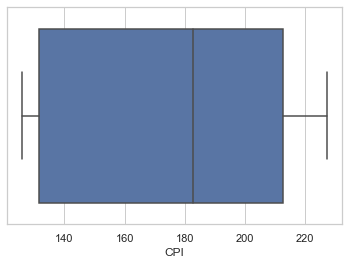

In [21]:
# Ящик с усами для столбца CPI
sns.boxplot(x=data['CPI'])
plt.show()

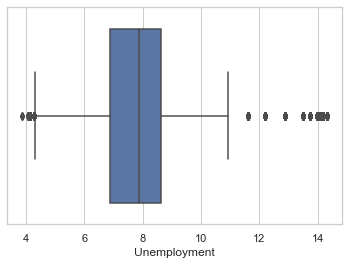

In [22]:
# Ящик с усами для столбца Unemployment
sns.boxplot(x=data['Unemployment'])
plt.show()

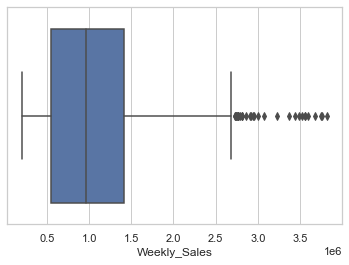

In [23]:
# Ящик с усами для столбца Unemployment
sns.boxplot(x=data['Weekly_Sales'])
plt.show()

Как видно из графиков в столбцах Temperature, Unemployment и Weekly_Sales есть выбросы.


### Очистка выбросов

Очистим столбцы с выбросами с помощью межквартильного размаха.

In [24]:
# Очистка столбца Temperature
Q1, Q3 = data['Temperature'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.5*IQR
max_limit = Q3 + 1.5*IQR

data_without_outliers = data[(data['Temperature'] > min_limit) & (data['Temperature'] < max_limit)]
data_without_outliers.shape

(6432, 10)

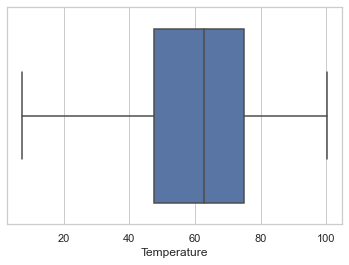

In [25]:
# Ящик с усами для столбца Temperature
sns.boxplot(x=data_without_outliers['Temperature'])
plt.show()

In [26]:
# Очистка столбца Unemployment
Q1, Q3 = data['Unemployment'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.3*IQR
max_limit = Q3 + 1.3*IQR

data_without_outliers = data_without_outliers[(data_without_outliers['Unemployment'] > min_limit)
                                              & (data_without_outliers['Unemployment'] < max_limit)]
data_without_outliers.shape

(5832, 10)

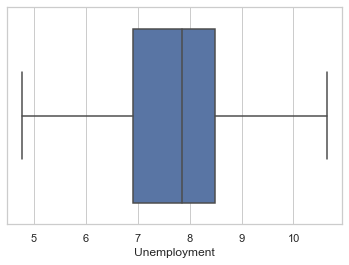

In [27]:
# Ящик с усами для столбца Unemployment
sns.boxplot(x=data_without_outliers['Unemployment'])
plt.show()

In [28]:
# Очистка столбца Weekly_Sales
Q1, Q3 = data['Weekly_Sales'].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.5*IQR
max_limit = Q3 + 1.5*IQR

data_without_outliers = data_without_outliers[(data_without_outliers['Weekly_Sales'] > min_limit)
                                              & (data_without_outliers['Weekly_Sales'] < max_limit)]
data_without_outliers.shape

(5798, 10)

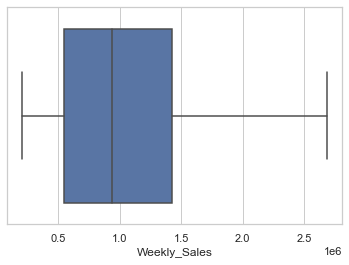

In [29]:
# Ящик с усами для столбца Weekly_Sales
sns.boxplot(x=data_without_outliers['Weekly_Sales'])
plt.show()

In [30]:
# Сравнение количества строк до очистки и после
print('Cтрок до очистки от выбросов: {};\nПослe очистки: {}.'
      .format(data.shape[0], data_without_outliers.shape[0]))

Cтрок до очистки от выбросов: 6435;
Послe очистки: 5798.



### Корреляционный анализ

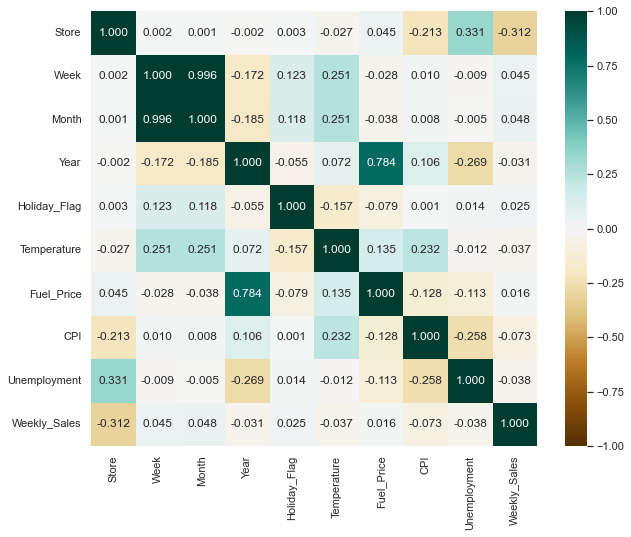

In [31]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10,8))
sns.heatmap(data=data_without_outliers.corr(), vmin=-1, vmax=1, annot=True, fmt='.3f', cmap='BrBG')
plt.show()

Из данной корреляционной матрицы можем сделать следующие выводы:
- Все нецелевые признаки имеют слабую связь с целевым (Weekly_Sales). Сильнее всего коррилиует признак Store;
- Признаки Week и Month практически линейно зависимы друг от друга. Оставим только признак Week;
- Признаки Year и Fuel_Price тоже сильно коррелируют друг с другом. Оставим признак Year.

In [32]:
# Удаление лишних колонок
data_corrected = data_without_outliers.drop(columns=['Month', 'Fuel_Price'])
data_corrected.head()

,Store,Week,Year,Holiday_Flag,Temperature,CPI,Unemployment,Weekly_Sales
0,1,5,2010,0,42.31,211.096358,8.106,1643690.90
1,1,6,2010,1,38.51,211.242170,8.106,1641957.44
2,1,7,2010,0,39.93,211.289143,8.106,1611968.17
3,1,8,2010,0,46.63,211.319643,8.106,1409727.59
4,1,9,2010,0,46.50,211.350143,8.106,1554806.68



### Масштабирование признаков

Для обучения метрических моделей (линейных и SVM) нужно отмасштабировать данные:

In [33]:
# Масштабирование
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X=data_corrected.drop(columns=['Weekly_Sales']),
                                       y=data_corrected['Weekly_Sales'])

In [34]:
# Вставка отмасштабированных данных
data_scaled = pd.DataFrame(scaled_features, columns=data_corrected.columns[:-1])
data_scaled.head()

,Store,Week,Year,Holiday_Flag,Temperature,CPI,Unemployment
0,0.0,0.078431,0.0,0.0,0.376025,0.840500,0.567406
1,0.0,0.098039,0.0,1.0,0.335024,0.841941,0.567406
2,0.0,0.117647,0.0,0.0,0.350345,0.842405,0.567406
3,0.0,0.137255,0.0,0.0,0.422637,0.842707,0.567406
4,0.0,0.156863,0.0,0.0,0.421234,0.843008,0.567406



### Разбиение выборки


In [35]:
X = data_scaled
y = data_corrected['Weekly_Sales']

X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [36]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((4638, 7), (4638,))

In [37]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((1160, 7), (1160,))


### Оценка качества моделей

Заранее создадим функцию для оценки качества моделей. В качестве метрик будем использовать среднюю абсолютную ошибку (MAE), среднюю квадратичную ошибку (MSE) и коэффициент детерминации (R2).

In [38]:
def model_scoring(y_true, y_pred):
    """
    Функия для оценки качества модели

    :param y_true: Истинные значения целевого признака
    :param y_pred: Предсказанные значения целевого признака
    """

    print('MAE: {};'.format(mean_absolute_error(y_true, y_pred)))
    print('MSE: {};'.format(mean_squared_error(y_true, y_pred)))
    print('R2: {}.'.format(r2_score(y_true, y_pred)))


### Линейные модели

#### Линейная регрессия


In [39]:
# Обучение модели линейной регресии (метод наименьших квадратов)
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression()

In [40]:
# Предсказания модели линейной регрессии на тестовой выборке
lr_pred = linear_regressor.predict(X_test)

In [41]:
# Оценка качества модели
model_scoring(y_test, lr_pred)

MAE: 423920.27711700025;
MSE: 257625596477.3987;
R2: 0.14267600093327137.



#### Гребневая регрессия

In [42]:
# Значения коэффициента альфа
alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [43]:
%%time
# Обучение модели гребневой регресии с оптимизацией гиперпараметров
ridge_regressor = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_absolute_error')
ridge_regressor.fit(X_train, y_train)

CPU times: total: 688 ms
Wall time: 187 ms


RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        cv=10, scoring='neg_mean_absolute_error')

In [44]:
# Значение коэффициента альфа
ridge_regressor.alpha_

0.001

In [45]:
# Лучшее значение метрики
-ridge_regressor.best_score_

436660.0078054334

In [46]:
# Предсказания модели гребневой регрессии на тестовой выборке
rr_pred = ridge_regressor.predict(X_test)

In [47]:
# Оценка качества модели
model_scoring(y_test, rr_pred)

MAE: 423920.3362302436;
MSE: 257625621243.2485;
R2: 0.142675918517713.



#### Lasso-регрессия


In [48]:
%%time
# Обучение модели lasso-регресии с оптимизацией гиперпараметров
lasso_regressor = LassoCV(cv=10)
lasso_regressor.fit(X_train, y_train)

CPU times: total: 562 ms
Wall time: 281 ms


LassoCV(cv=10)

In [49]:
# Значение коэффициента альфа
lasso_regressor.alpha_

323.8149151548691

In [50]:
# Предсказания модели lasso-регресии на тестовой выборке
lsr_pred = lasso_regressor.predict(X_test)

In [51]:
# Оценка качества модели
model_scoring(y_test, lsr_pred)

MAE: 424048.4893279474;
MSE: 257688096730.21973;
R2: 0.14246801318894842.



#### Elastic net


In [52]:
%%time
# Обучение модели elastic net с оптимизацией гиперпараметров
elastic_net_regressor = ElasticNetCV(alphas=alphas, cv=10)
elastic_net_regressor.fit(X_train, y_train)

CPU times: total: 141 ms
Wall time: 46.9 ms


ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=10)

In [53]:
# Значение альфа
elastic_net_regressor.alpha_

0.001

In [54]:
# Значение L1 Ratio
elastic_net_regressor.l1_ratio_

0.5

In [55]:
# Предсказания модели elastic net на тестовой выборке
en_pred = elastic_net_regressor.predict(X_test)

In [56]:
# Оценка качества модели
model_scoring(y_test, en_pred)

MAE: 424056.7185774579;
MSE: 257684423077.42242;
R2: 0.14248023833563583.



#### Полиномиальная регрессия


In [57]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'polynomialfeatures__degree' : np.arange(2, 6, 1, dtype=int),
                      'linearregression__fit_intercept' : [True, False]}

In [58]:
def PolynomialRegression (degree=2, **kwargs):
    """
     Функция полиномиальной регресии

    :param degree: Степень полинома
    :param kwargs: Аргументы для линейной регресии
    :return: Конвейер, создающий полиномиальную регресию
    """
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [59]:
%%time
# Оптимизация гиперпараметров
pr_gs = GridSearchCV(PolynomialRegression(), parameters_to_tune, cv=10,
                     scoring='neg_mean_absolute_error')
pr_gs.fit(X_train, y_train)

CPU times: total: 54.8 s
Wall time: 13.7 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__fit_intercept': [True, False],
                         'polynomialfeatures__degree': array([2, 3, 4, 5])},
             scoring='neg_mean_absolute_error')

In [60]:
# Лучшее значение параметров
pr_gs.best_params_

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 5}

In [61]:
# Лучшее значение метрики
-pr_gs.best_score_

211562.11876110715

In [62]:
# Обучение модели
polynomial_regressor = pr_gs.best_estimator_
polynomial_regressor.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

In [63]:
# Предсказания модели полиномиальной регресии на тестовой выборке
pr_pred = polynomial_regressor.predict(X_test)

In [64]:
# Оценка качества модели
model_scoring(y_test, pr_pred)

MAE: 201887.93549039707;
MSE: 111625696311.44235;
R2: 0.6285330740855575.


Среди линейных моделей лучший результат показала полиномиальная регрессия.


### Метод опорных векторов (SVM)

#### Линейный регрессор на SVM

In [65]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 1e+4, 1e+6]}

In [66]:
%%time
# Оптимизация гиперпараметров
lsvr_gs = GridSearchCV(LinearSVR(max_iter=10000), parameters_to_tune, cv=10, scoring='neg_mean_absolute_error')
lsvr_gs.fit(X_train, y_train)

CPU times: total: 969 ms
Wall time: 387 ms


GridSearchCV(cv=10, estimator=LinearSVR(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,
                               10000.0, 1000000.0]},
             scoring='neg_mean_absolute_error')

In [67]:
# Лучшее значение параметров
lsvr_gs.best_params_

{'C': 1000000.0}

In [68]:
# Лучшее значение метрики
-lsvr_gs.best_score_

430158.8430147623

In [69]:
# Обучение модели
linear_svr = lsvr_gs.best_estimator_
linear_svr.fit(X_train, y_train)

LinearSVR(C=1000000.0, max_iter=10000)

In [70]:
# Предсказания модели линейной регресии на SVM на тестовой выборке
lsvr_pred = linear_svr.predict(X_test)

In [71]:
# Оценка качества модели
model_scoring(y_test, lsvr_pred)

MAE: 415635.2348779928;
MSE: 264903233842.2666;
R2: 0.1184575488278986.



#### Регрессор на основе SVM с поддержкой параметра nu

##### Полиномиальное ядро


In [72]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'nu' : [0.1, 0.5, 1.0],
                      'C': [10.0, 100.0, 1000.0, 1e+4],
                      'degree' : [3, 4, 5]}

In [73]:
%%time
# Оптимизация гиперпараметров
nusvr_poly_gs = GridSearchCV(NuSVR(kernel='poly'), parameters_to_tune, cv=5, scoring='neg_mean_absolute_error')
nusvr_poly_gs.fit(X_train, y_train)

CPU times: total: 1min 23s
Wall time: 1min 23s


GridSearchCV(cv=5, estimator=NuSVR(kernel='poly'),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0],
                         'degree': [3, 4, 5], 'nu': [0.1, 0.5, 1.0]},
             scoring='neg_mean_absolute_error')

In [74]:
# Лучшее значение параметров
nusvr_poly_gs.best_params_

{'C': 10000.0, 'degree': 5, 'nu': 1.0}

In [75]:
# Лучшее значение метрики
-nusvr_poly_gs.best_score_

361981.3777801391

In [76]:
# Обучение модели
nusvr_poly = nusvr_poly_gs.best_estimator_
nusvr_poly.fit(X_train, y_train)

NuSVR(C=10000.0, degree=5, kernel='poly', nu=1.0)

In [77]:
# Предсказания модели регрессора на основе SVM с поддержкой параметра nu
# на тестовой выборке (kernel='poly')
nusvr_poly_pred = nusvr_poly.predict(X_test)

In [78]:
# Оценка качества модели
model_scoring(y_test, nusvr_poly_pred)

MAE: 356473.8363776097;
MSE: 233430267510.63614;
R2: 0.2231929855502861.



##### Ядро RBF


In [79]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'nu' : [0.1, 0.5, 1.0],
                      'C': [10.0, 100.0, 1000.0, 1e+4]}

In [80]:
%%time
# Оптимизация гиперпараметров
nusvr_rbf_gs =GridSearchCV(NuSVR(), parameters_to_tune, cv=5, scoring='neg_mean_absolute_error')
nusvr_rbf_gs.fit(X_train, y_train)

CPU times: total: 33 s
Wall time: 33 s


GridSearchCV(cv=5, estimator=NuSVR(),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0],
                         'nu': [0.1, 0.5, 1.0]},
             scoring='neg_mean_absolute_error')

In [81]:
# Лучшее значение параметров
nusvr_rbf_gs.best_params_

{'C': 10000.0, 'nu': 1.0}

In [82]:
# Лучшее значение метрики
-nusvr_rbf_gs.best_score_

412800.1647125642

In [83]:
# Обучение модели
nusvr_rbf = nusvr_rbf_gs.best_estimator_
nusvr_rbf.fit(X_train, y_train)

NuSVR(C=10000.0, nu=1.0)

In [84]:
# Предсказания модели регрессора на основе SVM с поддержкой параметра nu
# на тестовой выборке (kernel='rbf')
nusvr_rbf_pred = nusvr_rbf.predict(X_test)

In [85]:
# Оценка качества модели
model_scoring(y_test, nusvr_rbf_pred)

MAE: 395850.6580841526;
MSE: 242148091323.81406;
R2: 0.19418189473917347.



#### Регрессор на основе SVM

##### Полиномиальное ядро

In [86]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'degree': [3, 4, 5],
                      'coef0': np.arange(0, 8, 2.5, dtype=float),
                      'C' : [10.0, 100.0, 1000.0, 1e+4]}

In [87]:
%%time
# Оптимизация гиперпараметров
svr_poly_gs = GridSearchCV(SVR(kernel='poly'), parameters_to_tune, cv=5, scoring='neg_mean_absolute_error')
svr_poly_gs.fit(X_train, y_train)

CPU times: total: 22min 6s
Wall time: 22min 8s


GridSearchCV(cv=5, estimator=SVR(kernel='poly'),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0],
                         'coef0': array([0. , 2.5, 5. , 7.5]),
                         'degree': [3, 4, 5]},
             scoring='neg_mean_absolute_error')

In [88]:
# Лучшее значение параметров
svr_poly_gs.best_params_

{'C': 10000.0, 'coef0': 7.5, 'degree': 5}

In [89]:
# Лучшее значение метрики
-svr_poly_gs.best_score_

309350.0162170926

In [90]:
# Обучение модели
svr_poly = svr_poly_gs.best_estimator_
svr_poly.fit(X_train, y_train)

SVR(C=10000.0, coef0=7.5, degree=5, kernel='poly')

In [91]:
# Предсказания модели регрессора на основе SVM на тестовой выборке (kernel='poly')
svr_poly_pred = svr_poly.predict(X_test)

In [92]:
# Оценка качества модели
model_scoring(y_test, svr_poly_pred)

MAE: 288879.6258881801;
MSE: 177620082469.26093;
R2: 0.40891758622102536.



##### Ядро RBF

In [93]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'C' : [10.0, 100.0, 1000.0, 1e+4],
                      'epsilon' : np.linspace(0.1, 0.5, 5)}

In [94]:
%%time
# Оптимизация гиперпараметров
svr_rbf_gs = GridSearchCV(SVR(), parameters_to_tune, cv=5, scoring='neg_mean_absolute_error')
svr_rbf_gs.fit(X_train, y_train)

CPU times: total: 1min 24s
Wall time: 1min 25s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0],
                         'epsilon': array([0.1, 0.2, 0.3, 0.4, 0.5])},
             scoring='neg_mean_absolute_error')

In [95]:
# Лучшее значение параметров
svr_rbf_gs.best_params_

{'C': 10000.0, 'epsilon': 0.5}

In [96]:
# Лучшее значение метрики
-svr_rbf_gs.best_score_

412800.14315372304

In [97]:
# Обучение модели
svr_rbf = svr_rbf_gs.best_estimator_
svr_rbf.fit(X_train, y_train)

SVR(C=10000.0, epsilon=0.5)

In [98]:
# Предсказания модели регрессора на основе SVM на тестовой выборке (kernel='rbf')
svr_rbf_pred = svr_rbf.predict(X_test)

In [99]:
# Оценка качества модели
model_scoring(y_test, svr_rbf_pred)

MAE: 395850.6437803071;
MSE: 242148058812.87177;
R2: 0.19418200292877674.


Среди моделей SVM лучший результат показала модель регрессора на основе SVM с полиномиальным ядром


### Дерево решений

Для начала разделим неотмасштабированные данные на обучающую и тестовую выборки:

In [100]:
X = data_corrected.drop(columns=['Weekly_Sales'])
y = data_corrected['Weekly_Sales']

X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [101]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'max_depth' : [3, 4, 5, 6, 7, 8],
                      'min_samples_leaf' : np.linspace(0.01, 0.1, 10),
                      'max_features' : [0.2 , 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2']}

In [102]:
%%time
# Оптимизация гиперпараметров
dtr_gs = GridSearchCV(DecisionTreeRegressor(criterion='absolute_error', random_state=8),
                      parameters_to_tune, cv=5, scoring='neg_mean_absolute_error')
dtr_gs.fit(X_train, y_train)

CPU times: total: 3min 44s
Wall time: 3min 44s


GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             random_state=8),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 'auto', 'sqrt',
                                          'log2'],
                         'min_samples_leaf': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
             scoring='neg_mean_absolute_error')

In [103]:
# Лучшее значение параметров
dtr_gs.best_params_

{'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 0.01}

In [104]:
# Лучшее значение метрики
-dtr_gs.best_score_

163192.3770197755

In [105]:
# Обучение модели
dt_regressor = dtr_gs.best_estimator_
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=8, max_features=0.8,
                      min_samples_leaf=0.01, random_state=8)

In [106]:
# Предсказания модели регрессора на основе дерева решений
dt_pred = dt_regressor.predict(X_test)

In [107]:
# Оценка качества модели
model_scoring(y_test, dt_pred)

MAE: 145622.8389310345;
MSE: 64213760985.04038;
R2: 0.7863100595765546.


In [108]:
# Визуализация дерева с помощью текста
tree_rules = export_text(dt_regressor, feature_names=list(X_train.columns))
print(tree_rules)

|--- Store <= 2.50
|   |--- Store <= 1.50
|   |   |--- CPI <= 213.68
|   |   |   |--- value: [1493334.82]
|   |   |--- CPI >  213.68
|   |   |   |--- value: [1541102.38]
|   |--- Store >  1.50
|   |   |--- CPI <= 214.61
|   |   |   |--- value: [1904608.09]
|   |   |--- CPI >  214.61
|   |   |   |--- value: [1857480.84]
|--- Store >  2.50
|   |--- CPI <= 198.10
|   |   |--- Store <= 14.50
|   |   |   |--- Temperature <= 30.73
|   |   |   |   |--- value: [596802.76]
|   |   |   |--- Temperature >  30.73
|   |   |   |   |--- CPI <= 189.36
|   |   |   |   |   |--- CPI <= 156.42
|   |   |   |   |   |   |--- Unemployment <= 6.91
|   |   |   |   |   |   |   |--- value: [2036274.46]
|   |   |   |   |   |   |--- Unemployment >  6.91
|   |   |   |   |   |   |   |--- Temperature <= 65.51
|   |   |   |   |   |   |   |   |--- value: [1917483.10]
|   |   |   |   |   |   |   |--- Temperature >  65.51
|   |   |   |   |   |   |   |   |--- value: [1808781.33]
|   |   |   |   |   |--- CPI >  156.42
|   |

In [109]:
# Генерация графа дерева с помощью библиотеки graphviz
dot_data = export_graphviz(dt_regressor, feature_names=list(X_train.columns),
                            filled=True, rounded=True, special_characters=True, rotate=True)
graph = graphviz.Source(dot_data, format='svg', directory='images', filename='graph', engine='dot')
graph.render()

'images\\graph.svg'

In [110]:
# Визуализация дерева с помощью графа
from IPython.core.display import HTML
HTML('<img src="images/graph.svg" width=100%>')

In [111]:
# Важность признаков
dt_regressor.feature_importances_

array([0.7375566 , 0.00235775, 0.        , 0.        , 0.02937484,
       0.14294334, 0.08776746])

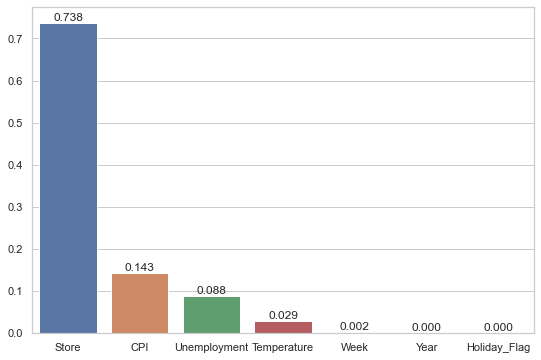

In [112]:
# Визуализация важности признаков
from operator import itemgetter
feature_importance_list = list(zip(X_train.columns.values, dt_regressor.feature_importances_))
sorted_list = sorted(feature_importance_list, key=itemgetter(1), reverse=True)
feature_order = [x for x, _ in sorted_list]

plt.figure(figsize=(9,6))
bar_plot = sns.barplot(x=X_train.columns.values, y=dt_regressor.feature_importances_, order=feature_order)
bar_plot.bar_label(bar_plot.containers[-1], fmt='%.3f')
plt.show()

Обучим ещё одну модель, но с признаками отсортированными по важности:

In [113]:
# Обучающие и тестовые выборки, отсортированные по важности
X_sorted = data_corrected[feature_order]
y = data_corrected['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X_sorted, y, test_size=0.2, random_state=8)

In [114]:
# Обучение новой модели
dt_regressor_sorted = dtr_gs.best_estimator_
dt_regressor_sorted.fit(X_train[X_train.columns[0:3]], y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=8, max_features=0.8,
                      min_samples_leaf=0.01, random_state=8)

In [115]:
# Предсказание, сделанное с помощью новой модели
dt_sorted_pred = dt_regressor_sorted.predict(X_test[X_test.columns[0:3]])

In [116]:
# Оценка качества модели
model_scoring(y_test, dt_sorted_pred)

MAE: 193870.63220689655;
MSE: 118802014278.92172;
R2: 0.6046517917029912.


Регрессор на основе дерева решений показал лучший результат.